In [1]:
import os, sys
import pandas as pd
import numpy as np
import numpy.matlib
import scipy as sp

import geopandas as gpd
from fbprophet import Prophet

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

Importing plotly failed. Interactive plots will not work.


In [2]:
my_map = gpd.read_file('/Users/lindenmp/Dropbox/PersonalProjects/NASA_aus_firedata/data/my_map.shp')

In [3]:
df = gpd.read_file('/Users/lindenmp/Dropbox/PersonalProjects/NASA_aus_firedata/data/df_postcode.shp')
df.shape

(450028, 17)

In [4]:
df.head()

,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT,CONFIDENCE,VERSION,BRIGHT_T31,FRP,DAYNIGHT,TYPE,postcode,geometry
0,-30.5863,151.2951,325.7,1.0,1.0,2000-11-01,0019,Terra,MODIS,80,6.2,293.9,18.1,D,0,2358,POINT (151.29510 -30.58630)
1,-30.5773,151.2968,313.0,1.0,1.0,2000-11-01,0019,Terra,MODIS,52,6.2,294.5,6.1,D,0,2358,POINT (151.29680 -30.57730)
2,-30.7754,151.1438,342.8,1.0,1.0,2000-11-01,0019,Terra,MODIS,80,6.2,294.2,42.9,D,0,2355,POINT (151.14380 -30.77540)
3,-30.3560,151.7422,316.8,1.0,1.0,2000-11-01,0019,Terra,MODIS,69,6.2,295.7,9.0,D,0,2365,POINT (151.74220 -30.35600)
4,-31.5540,147.0632,318.9,1.3,1.1,2000-11-01,0020,Terra,MODIS,73,6.2,296.2,12.6,D,0,2825,POINT (147.06320 -31.55400)


Add some columns that denote year and month

In [5]:
df['year'] = pd.DatetimeIndex(df['ACQ_DATE']).year
df['month'] = pd.DatetimeIndex(df['ACQ_DATE']).month

Check we have a full years data for each year

In [6]:
num_months = np.zeros(len(df['year'].unique()),)

for i, year in enumerate(df['year'].unique()):
    num_months[i] = len(df.loc[df['year'] == year,'month'].unique())

Text(0, 0.5, 'Counts')

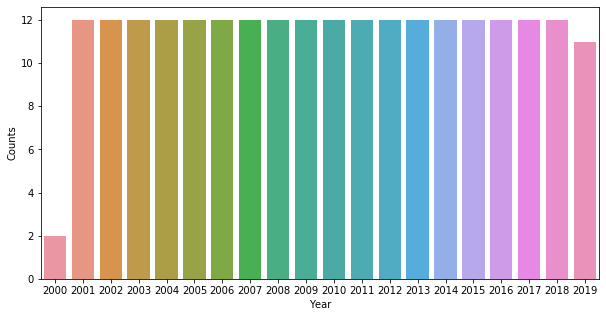

In [7]:
fig, ax = plt.subplots(figsize = (10,5))
sns.barplot(x = df['year'].unique(),
            y = num_months, ax = ax)
ax.set_xlabel('Year')
ax.set_ylabel('Counts')

Nope, drop year 2000

In [8]:
# drop year 2000
df = df.loc[df['year'] > 2000,:]

In [9]:
# What's going on for 2019? - Missing october..
df.loc[df['year'] == 2019,'month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12])

# Exploratory data analysis

Text(0, 0.5, 'Counts')

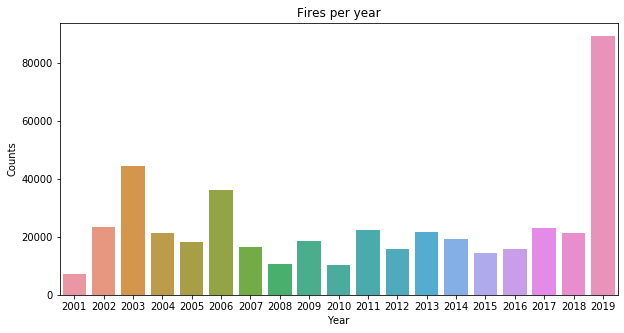

In [10]:
fig, ax = plt.subplots(figsize = (10,5))
sns.barplot(x = df['year'].value_counts().index,
            y = df['year'].value_counts().values, ax = ax)
ax.set_title('Fires per year')
ax.set_xlabel('Year')
ax.set_ylabel('Counts')

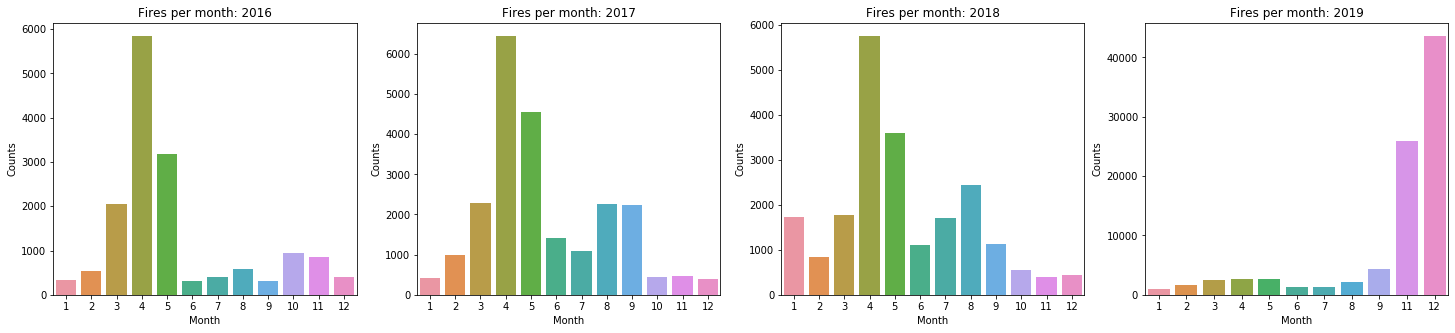

In [11]:
years = (2016, 2017, 2018, 2019)
fig, ax = plt.subplots(1,4, figsize = (25,5))
for i, year in enumerate(years):
    sns.barplot(x = df.loc[df['year'] == year,'month'].value_counts().index,
                y =df.loc[df['year'] == year,'month'].value_counts().values, ax = ax[i])
    ax[i].set_title('Fires per month: ' + str(year))
    ax[i].set_xlabel('Month')
    ax[i].set_ylabel('Counts')

## Spatial plots

Plot the fires on Dec 31st 2019, during the big surge of bushfires

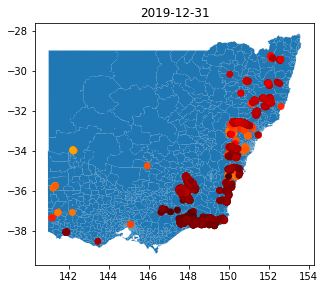

In [12]:
my_date = df['ACQ_DATE'].unique()[-1]
fig, ax = plt.subplots(figsize = (5,5))
ax.set_title(my_date)
my_map.plot(ax = ax)
df[df['ACQ_DATE'] == my_date].plot(ax = ax, column='BRIGHT_T31', cmap='hot')

Let's look over a period of years, normalized by number of fires across the same period

In [13]:
years = (2016, 2017, 2018, 2019)
num_fires = np.zeros(1,)
for year in years:
    num_fires = num_fires + df.loc[df['year'] == year,:].shape[0]

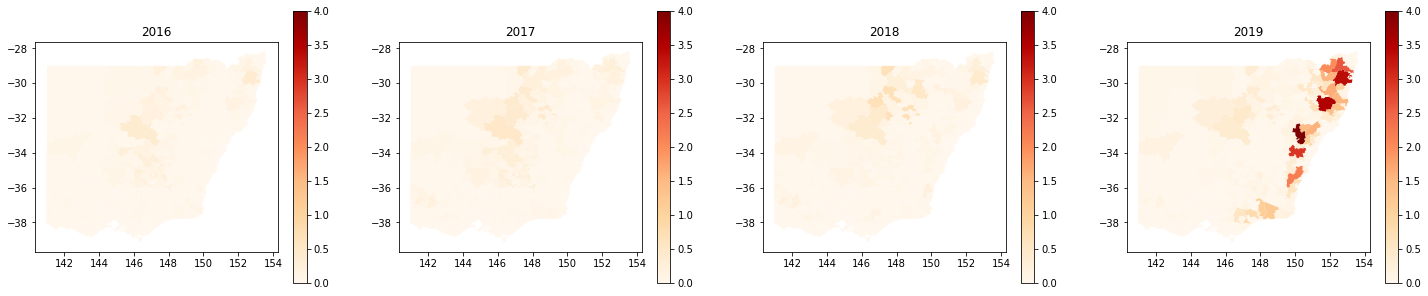

In [14]:
fig, ax = plt.subplots(1,4, figsize = (25,5))
for i, year in enumerate(years):
    counts = df.loc[df['year'] == year,'postcode'].value_counts()

    my_map['counts'] = np.zeros(my_map.shape[0],)

    for postcode in counts.index:
        my_map.loc[my_map['code'] == postcode, 'counts'] = counts[postcode] / num_fires * 100

    ax[i].set_title(year)
    my_map.plot(ax = ax[i], column = 'counts', cmap='OrRd', vmax = 4, legend=True)

### Fit a simple time series forecasting model

In [15]:
# assemble dataframe of counts of fires per date
df_proph = pd.DataFrame()
df_proph['ds'] = df.groupby('ACQ_DATE').count().index
df_proph['y'] = df.groupby('ACQ_DATE').count().iloc[:,0].values

In [16]:
df_proph.head()

,ds,y
0,2001-01-01,1
1,2001-01-02,33
2,2001-01-03,29
3,2001-01-04,9
4,2001-01-05,6


In [17]:
# Make the prophet model and fit on the data
my_prophet = Prophet(changepoint_prior_scale=0.15)
my_prophet.fit(df_proph)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [18]:
# Make a future dataframe for 2 years
my_forecast = my_prophet.make_future_dataframe(periods=365, freq='D')
# Make predictions
my_forecast = my_prophet.predict(my_forecast)

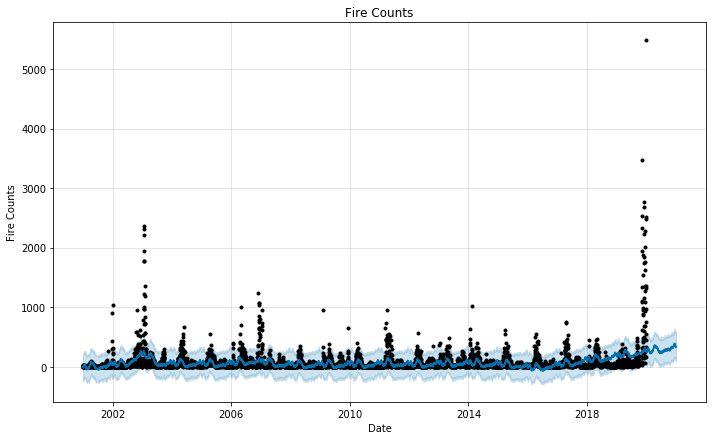

In [19]:
my_prophet.plot(my_forecast, xlabel = 'Date', ylabel = 'Fire Counts')
plt.title('Fire Counts');

Well, last yeaer certainly was a big ol' outlier

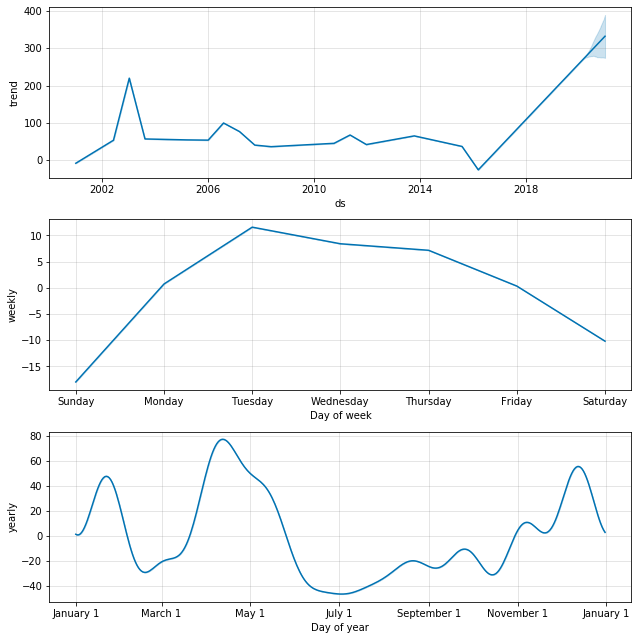

In [20]:
# Plot the trends and patterns
my_prophet.plot_components(my_forecast);

## Regional plots

Let's pull out a region in NSW that regularly has fires

In [21]:
postcodes = (2877, 2875, 2873, 2825, 2835)
my_region = gpd.GeoDataFrame()
df_region = pd.DataFrame()
for postcode in postcodes:
    region_tmp = my_map[my_map['code'] == postcode]
    df_tmp = df.loc[df['postcode'] == postcode,:]
    
    my_region = pd.concat((my_region, region_tmp), axis = 0)
    df_region = pd.concat((df_region, df_tmp), axis = 0)

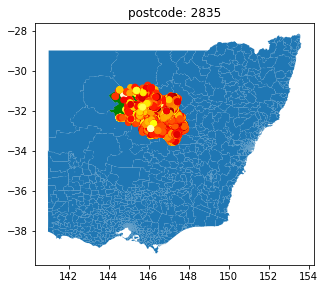

In [22]:
fig, ax = plt.subplots(figsize = (5,5))
ax.set_title('postcode: ' + str(postcode))
my_map.plot(ax = ax)
my_region.plot(ax = ax, color = 'g')
df_region.plot(ax = ax, column='BRIGHT_T31', cmap='hot')

Text(0, 0.5, 'Counts')

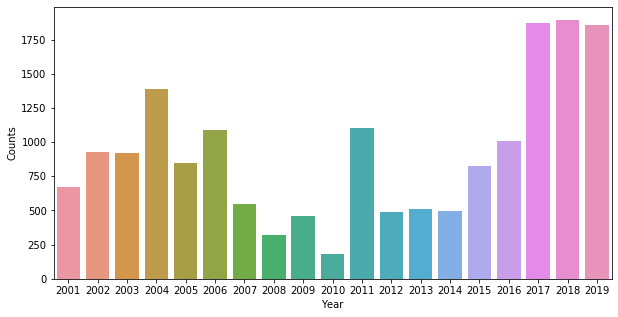

In [23]:
fig, ax = plt.subplots(figsize = (10,5))
sns.barplot(x = df_region[['year','month']].groupby('year').count().index,
            y = df_region[['year','month']].groupby('year').count().values.reshape(-1), ax = ax)
ax.set_xlabel('Year')
ax.set_ylabel('Counts')

### Fit time series forecasting model

In [24]:
# assemble dataframe of counts of fires per date
df_proph = pd.DataFrame()
df_proph['ds'] = df_region.groupby('ACQ_DATE').count().index
df_proph['y'] = df_region.groupby('ACQ_DATE').count().iloc[:,0].values

In [25]:
df_proph.head()

,ds,y
0,2001-01-08,1
1,2001-01-15,5
2,2001-01-16,3
3,2001-01-23,12
4,2001-01-28,6


In [26]:
# Make the prophet model and fit on the data
my_prophet = Prophet(changepoint_prior_scale=0.15)
my_prophet.fit(df_proph)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [27]:
# Make a future dataframe for 2 years
my_forecast = my_prophet.make_future_dataframe(periods=365, freq='D')
# Make predictions
my_forecast = my_prophet.predict(my_forecast)

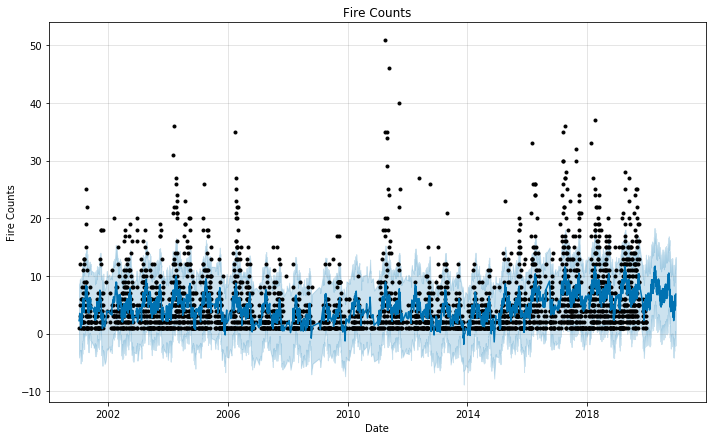

In [28]:
my_prophet.plot(my_forecast, xlabel = 'Date', ylabel = 'Fire Counts')
plt.title('Fire Counts');

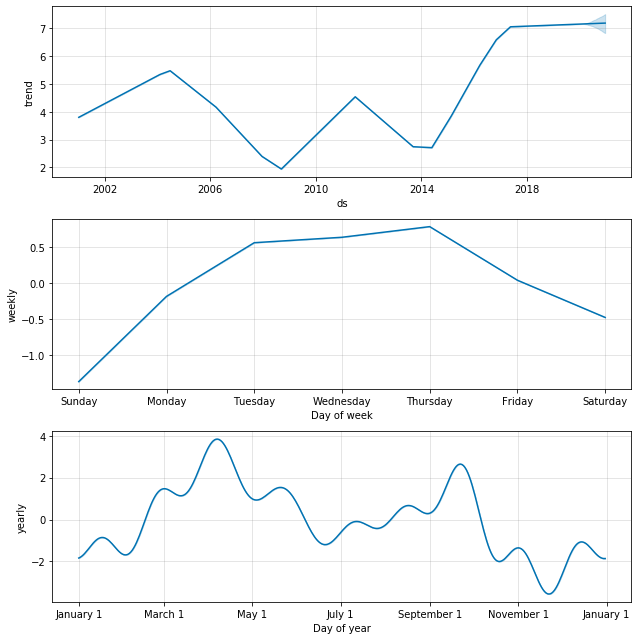

In [29]:
# Plot the trends and patterns
my_prophet.plot_components(my_forecast);